## **Step 1 - keywords Extraction**
***

We have two datasets, one with dream text descriptions:

In [1]:
from keyword_extractor import read_datasets, extract_and_save_keywords_from_dataframes
from yaml_parser import load_config
config = load_config()
dream_df, keywords_df = read_datasets(config)
dream_df.head()

,dream_id,dreamer,description,dream_date,dream_language,text_dream,characters_code,emotions_code,aggression_code,friendliness_code,...,Animal,Friends,Family,Dead&Imaginary,Aggression/Friendliness,A/CIndex,F/CIndex,S/CIndex,NegativeEmotions,Dream Symbol
0,1,alta,Alta: a detailed dreamer,1957,en,"The one at the Meads's house, where it's bigge...","2ISA, 1MKA, 1FDA, 1IOA, 2ISA",NaN,2IKA > Q,2IKA 4> Q,...,0.000000,0.200000,0.200000,0.0,0.000,0.200000,0.200000,0.0,0.0,"Upstairs,Haunted House,Maid,Tea House,Mansion"
1,2,alta,Alta: a detailed dreamer,8/11/1967,en,I'm at a family reunion in a large fine house ...,"2ISA, people, 2ISA",SD 2IKA,"D > Q, Q > 2ISA",NaN,...,0.000000,0.000000,0.000000,0.0,1.000,0.666667,0.000000,0.0,1.0,"Fainting,Vertigo,Near Death Experience,Landsli..."
2,3,alta,Alta: a detailed dreamer,8/1/1985,en,I watch a plane fly past and shortly realize i...,"2ISA, 2ISA, 1FSA, 1MBA, 1IOA, 2ISA, 2FDA","SD 1ISA, AP D, AP D","It PRP >, It PRP >, D > 1FKA",NaN,...,0.000000,0.000000,0.285714,0.0,1.000,0.428571,0.000000,0.0,1.0,"Kidnap,Emergency Alert,Death Penalty,Abortion,..."
3,4,alta,Alta: a detailed dreamer,1985?,en,Me pulling the green leaves and berries off so...,"1MAA, 1FMA, 2ISA, 2IKA, 1ANI, 1ANI, 1IOA, 2ISA...","SD 2ISA, SD D","Q > Q, 2ISA > Q, 2ISA > Q, D > 1MSA","1IKA 4> Q, 2ISA 4> 2ISA",...,0.176471,0.142857,0.142857,0.0,1.000,0.235294,0.117647,0.0,1.0,"Kidnap,Knocking,Party,Sabotage,Paranormal"
4,5,alta,Alta: a detailed dreamer,1985?,en,I'm in a room that reminds me of (but definite...,"1IRA, 1MSA, 1ISA, 2ISA, 1ISA, 1IKA","AP D, AP D, AP 1MSA, CO D, SD D, AP D","1MSA > D, Q > Q, D > 2IKA, D > 2IKA, D > 1MSA,...",D 4> Q,...,0.000000,0.166667,0.166667,0.0,0.875,1.333333,0.166667,0.0,1.0,"Haunted House,Paranormal,Near Death Experience..."


And another one with interpretations of dreams according to keywords:

In [2]:
keywords_df

,Dream Symbol,Interpretation
0,Aardvark,To see an aardvark in your dream indicates tha...
1,Abandonment,To dream that you are abandoned suggests that ...
2,Abduction,To dream of being abducted indicates that you ...
3,Aborigine,To see an Aborigine in your dream represents b...
4,Abortion,To dream that you have an abortion suggests th...
...,...,...
1193,Zip Line,To dream that you are zip lining implies that ...
1194,Zombie,To see or dream that you are a zombie suggests...
1195,Zoomorphism,To dream that you are changing into the form o...
1196,com Tambourine,To see or play a tambourine in your dream symb...


Then, we used a pretrained Sentence transformer to encode the dream embeddings and keyword embeddings and try to extract the most significant keywords from each dream.

### **all-MiniLM-L6-v2**
***

In [3]:
dream_df = extract_and_save_keywords_from_dataframes()
dream_df

,dream_id,dreamer,description,dream_date,dream_language,text_dream,characters_code,emotions_code,aggression_code,friendliness_code,...,Animal,Friends,Family,Dead&Imaginary,Aggression/Friendliness,A/CIndex,F/CIndex,S/CIndex,NegativeEmotions,Dream Symbol
0,1,alta,Alta: a detailed dreamer,1957,en,"The one at the Meads's house, where it's bigge...","2ISA, 1MKA, 1FDA, 1IOA, 2ISA",NaN,2IKA > Q,2IKA 4> Q,...,0.000000,0.200000,0.200000,0.0,0.000,0.200000,0.200000,0.0,0.0,"Upstairs,Haunted House,Maid,Tea House,Mansion"
1,2,alta,Alta: a detailed dreamer,8/11/1967,en,I'm at a family reunion in a large fine house ...,"2ISA, people, 2ISA",SD 2IKA,"D > Q, Q > 2ISA",NaN,...,0.000000,0.000000,0.000000,0.0,1.000,0.666667,0.000000,0.0,1.0,"Fainting,Vertigo,Near Death Experience,Landsli..."
2,3,alta,Alta: a detailed dreamer,8/1/1985,en,I watch a plane fly past and shortly realize i...,"2ISA, 2ISA, 1FSA, 1MBA, 1IOA, 2ISA, 2FDA","SD 1ISA, AP D, AP D","It PRP >, It PRP >, D > 1FKA",NaN,...,0.000000,0.000000,0.285714,0.0,1.000,0.428571,0.000000,0.0,1.0,"Kidnap,Emergency Alert,Death Penalty,Abortion,..."
3,4,alta,Alta: a detailed dreamer,1985?,en,Me pulling the green leaves and berries off so...,"1MAA, 1FMA, 2ISA, 2IKA, 1ANI, 1ANI, 1IOA, 2ISA...","SD 2ISA, SD D","Q > Q, 2ISA > Q, 2ISA > Q, D > 1MSA","1IKA 4> Q, 2ISA 4> 2ISA",...,0.176471,0.142857,0.142857,0.0,1.000,0.235294,0.117647,0.0,1.0,"Kidnap,Knocking,Party,Sabotage,Paranormal"
4,5,alta,Alta: a detailed dreamer,1985?,en,I'm in a room that reminds me of (but definite...,"1IRA, 1MSA, 1ISA, 2ISA, 1ISA, 1IKA","AP D, AP D, AP 1MSA, CO D, SD D, AP D","1MSA > D, Q > Q, D > 2IKA, D > 2IKA, D > 1MSA,...",D 4> Q,...,0.000000,0.166667,0.166667,0.0,0.875,1.333333,0.166667,0.0,1.0,"Haunted House,Paranormal,Near Death Experience..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,33062,west_coast_teens,West Coast teenage girls,"F, age 18",en,The dream was about me and my boyfriend going ...,"2ISA, 2ISA, 1ISA","HA D, AP D","2IKA > Q, D > D",NaN,...,0.000000,0.000000,0.000000,0.0,1.000,0.666667,0.000000,0.0,0.5,"Scared,Near Death Experience,Landslide,Paranor..."
20996,33063,west_coast_teens,West Coast teenage girls,"F, age 18",en,Two weeks ago this guy asked me to Senior Ball...,1ISA,HA D,NaN,NaN,...,0.000000,0.000000,0.000000,0.0,0.000,0.000000,0.000000,1.0,0.0,"Tap Dancing,Dance,Bait,Lake,Koi Fish"
20997,33064,west_coast_teens,West Coast teenage girls,"F, age 18",en,My boyfriend just broke up with me so he was o...,"1ISA, 1FSA",AP D,Q > D,NaN,...,0.000000,0.000000,0.000000,0.0,1.000,0.500000,0.000000,0.0,1.0,"Deja Vu,Fairy,Past Life,Fairy Tale,Ghost"
20998,33065,west_coast_teens,West Coast teenage girls,"F, age 18",en,I was in my backyard and I was flying. I would...,1ANI,AN 1ISA,"1ANI > D, 1ANI > Q, 1ISA 1> Q",NaN,...,1.000000,0.000000,0.000000,0.0,1.000,3.000000,0.000000,0.0,1.0,"Jumping,Near Death Experience,Landing,Leaping,..."


To view the dataframe better, We will filter out the interesting columns:

In [4]:
columns_to_show = ['text_dream', 'Dream Symbol']
dream_df[columns_to_show]

,text_dream,Dream Symbol
0,"The one at the Meads's house, where it's bigge...","Upstairs,Haunted House,Maid,Tea House,Mansion"
1,I'm at a family reunion in a large fine house ...,"Fainting,Vertigo,Near Death Experience,Landsli..."
2,I watch a plane fly past and shortly realize i...,"Kidnap,Emergency Alert,Death Penalty,Abortion,..."
3,Me pulling the green leaves and berries off so...,"Kidnap,Knocking,Party,Sabotage,Paranormal"
4,I'm in a room that reminds me of (but definite...,"Haunted House,Paranormal,Near Death Experience..."
...,...,...
20995,The dream was about me and my boyfriend going ...,"Scared,Near Death Experience,Landslide,Paranor..."
20996,Two weeks ago this guy asked me to Senior Ball...,"Tap Dancing,Dance,Bait,Lake,Koi Fish"
20997,My boyfriend just broke up with me so he was o...,"Deja Vu,Fairy,Past Life,Fairy Tale,Ghost"
20998,I was in my backyard and I was flying. I would...,"Jumping,Near Death Experience,Landing,Leaping,..."


## Step 2 - Summarize interpretations

After extracting the meaningful keywords, we tried to fetch the matching interpretation for each extracted keyword and use a pretrained LLM to summarize these interpretations into one interpretation.

### Load data and prepare (small) dataset for experimenting

In [5]:
import pandas as pd
from datetime import datetime
from transformers import pipeline
from utils import  release_all_gpu_memory, save_df_as_pretty_html


In [6]:
from summarizer import load_causal_model, batch_generate_interpretations
import torch

In [7]:
dream_df= pd.read_csv('datasets/rsos_dream_data.tsv', sep='\t')
dream_df

,dream_id,dreamer,description,dream_date,dream_language,text_dream,characters_code,emotions_code,aggression_code,friendliness_code,...,Animal,Friends,Family,Dead&Imaginary,Aggression/Friendliness,A/CIndex,F/CIndex,S/CIndex,NegativeEmotions,Dream Symbol
0,1,alta,Alta: a detailed dreamer,1957,en,"The one at the Meads's house, where it's bigge...","2ISA, 1MKA, 1FDA, 1IOA, 2ISA",NaN,2IKA > Q,2IKA 4> Q,...,0.000000,0.200000,0.200000,0.0,0.000,0.200000,0.200000,0.0,0.0,"Upstairs,Haunted House,Maid,Tea House,Mansion"
1,2,alta,Alta: a detailed dreamer,8/11/1967,en,I'm at a family reunion in a large fine house ...,"2ISA, people, 2ISA",SD 2IKA,"D > Q, Q > 2ISA",NaN,...,0.000000,0.000000,0.000000,0.0,1.000,0.666667,0.000000,0.0,1.0,"Fainting,Vertigo,Near Death Experience,Landsli..."
2,3,alta,Alta: a detailed dreamer,8/1/1985,en,I watch a plane fly past and shortly realize i...,"2ISA, 2ISA, 1FSA, 1MBA, 1IOA, 2ISA, 2FDA","SD 1ISA, AP D, AP D","It PRP >, It PRP >, D > 1FKA",NaN,...,0.000000,0.000000,0.285714,0.0,1.000,0.428571,0.000000,0.0,1.0,"Kidnap,Emergency Alert,Death Penalty,Abortion,..."
3,4,alta,Alta: a detailed dreamer,1985?,en,Me pulling the green leaves and berries off so...,"1MAA, 1FMA, 2ISA, 2IKA, 1ANI, 1ANI, 1IOA, 2ISA...","SD 2ISA, SD D","Q > Q, 2ISA > Q, 2ISA > Q, D > 1MSA","1IKA 4> Q, 2ISA 4> 2ISA",...,0.176471,0.142857,0.142857,0.0,1.000,0.235294,0.117647,0.0,1.0,"Kidnap,Knocking,Party,Sabotage,Paranormal"
4,5,alta,Alta: a detailed dreamer,1985?,en,I'm in a room that reminds me of (but definite...,"1IRA, 1MSA, 1ISA, 2ISA, 1ISA, 1IKA","AP D, AP D, AP 1MSA, CO D, SD D, AP D","1MSA > D, Q > Q, D > 2IKA, D > 2IKA, D > 1MSA,...",D 4> Q,...,0.000000,0.166667,0.166667,0.0,0.875,1.333333,0.166667,0.0,1.0,"Haunted House,Paranormal,Near Death Experience..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,33062,west_coast_teens,West Coast teenage girls,"F, age 18",en,The dream was about me and my boyfriend going ...,"2ISA, 2ISA, 1ISA","HA D, AP D","2IKA > Q, D > D",NaN,...,0.000000,0.000000,0.000000,0.0,1.000,0.666667,0.000000,0.0,0.5,"Scared,Near Death Experience,Landslide,Paranor..."
20996,33063,west_coast_teens,West Coast teenage girls,"F, age 18",en,Two weeks ago this guy asked me to Senior Ball...,1ISA,HA D,NaN,NaN,...,0.000000,0.000000,0.000000,0.0,0.000,0.000000,0.000000,1.0,0.0,"Tap Dancing,Dance,Bait,Lake,Koi Fish"
20997,33064,west_coast_teens,West Coast teenage girls,"F, age 18",en,My boyfriend just broke up with me so he was o...,"1ISA, 1FSA",AP D,Q > D,NaN,...,0.000000,0.000000,0.000000,0.0,1.000,0.500000,0.000000,0.0,1.0,"Deja Vu,Fairy,Past Life,Fairy Tale,Ghost"
20998,33065,west_coast_teens,West Coast teenage girls,"F, age 18",en,I was in my backyard and I was flying. I would...,1ANI,AN 1ISA,"1ANI > D, 1ANI > Q, 1ISA 1> Q",NaN,...,1.000000,0.000000,0.000000,0.0,1.000,3.000000,0.000000,0.0,1.0,"Jumping,Near Death Experience,Landing,Leaping,..."


In [8]:
keywords_df = pd.read_csv("datasets/fixed_interpretations.csv")
keywords_df

,Dream Symbol,Interpretation
0,Aardvark,To see an aardvark in your dream indicates tha...
1,Abandonment,To dream that you are abandoned suggests that ...
2,Abduction,To dream of being abducted indicates that you ...
3,Aborigine,To see an Aborigine in your dream represents b...
4,Abortion,To dream that you have an abortion suggests th...
...,...,...
1193,Zip Line,To dream that you are zip lining implies that ...
1194,Zombie,To see or dream that you are a zombie suggests...
1195,Zoomorphism,To dream that you are changing into the form o...
1196,com Tambourine,To see or play a tambourine in your dream symb...


In [9]:
exmpl = dream_df[dream_df["text_dream"].str.len()< 300]     # Limit the dream length

In [10]:
exmpl = exmpl[["text_dream","Dream Symbol"]].sample(5, random_state=45)     # Create sample

In [11]:
exmpl

,text_dream,Dream Symbol
4626,I had to do a dance combination with my friend...,"Dance Class,Dance,Ballet,Tap Dancing,Dance Floor"
10232,There was a war. This youngish guy was put on ...,"Man Of War,War,Violence,Genocide,King Kong"
5692,I need to go to the toilet. A small boy goes a...,"Urinal,Defecate,Urination,Car Seat,Laxative"
17466,A teenage boy was selling books on the street....,"Magazine,Teenager,Virgin Mary,Vatican,Reading"
11510,I woke up in the morning and it was really col...,"Weather,Eating,Nap,Rain,Sandwich"


In [12]:
exmpl["Dream Symbol"]   # keywords of the sample

4626     Dance Class,Dance,Ballet,Tap Dancing,Dance Floor
10232          Man Of War,War,Violence,Genocide,King Kong
5692          Urinal,Defecate,Urination,Car Seat,Laxative
17466       Magazine,Teenager,Virgin Mary,Vatican,Reading
11510                    Weather,Eating,Nap,Rain,Sandwich
Name: Dream Symbol, dtype: object

Now, we will create a prompt for the LLM. The prompt will include a request for the LLM to summarize the interpretations. It will get the dream description, the keywords, and the interpretations.

In [13]:
dataset = []

prmt = """Given dream description, interpret the meaning of the dream. 
Provided also are the dream symbols that appear in the dream and their meanings. 
Use the dream symbols meanings to help you interpret the dream. """.replace("\n", " ")


for i, ex in exmpl.iterrows():
    #print(ex)
    keys = ex["Dream Symbol"].split(",")[:5]
    
    #print(keys)
    syms = keywords_df[keywords_df["Dream Symbol"].isin(keys)]

    descr = syms.apply(lambda r: f' - {r["Dream Symbol"]}:  {r["Interpretation"]}', axis = 1)
    item = {
        "prompt": prmt, 
        "dream": ex["text_dream"],
        "symbols": "\n".join(descr),
        }
    dataset.append(item)
    

dataset = pd.DataFrame(dataset)
dataset


,prompt,dream,symbols
0,"Given dream description, interpret the meaning...",I had to do a dance combination with my friend...,- Ballet: To dream that you are watching a b...
1,"Given dream description, interpret the meaning...",There was a war. This youngish guy was put on ...,- Genocide: To dream about a genocide points...
2,"Given dream description, interpret the meaning...",I need to go to the toilet. A small boy goes a...,- Car Seat: To see an infant car seat in you...
3,"Given dream description, interpret the meaning...",A teenage boy was selling books on the street....,- Magazine: To read a magazine in your dream...
4,"Given dream description, interpret the meaning...",I woke up in the morning and it was really col...,- Eating: To dream that you are eating alone...


### Summarize with flan-T5-large model

In [14]:
release_all_gpu_memory()

clearing cuda cache
clearing ipc cache
✅ All GPU memory cleared.


In [15]:
# Step 1: Load FLAN-T5 model and tokenizer
model_name = "google/flan-t5-large"
model_name_short = model_name.split("/")[-1]
device = 0 if torch.cuda.is_available() else -1
model, tokenizer = load_causal_model(model_name)

In [16]:
text2text_generator = pipeline(
        "text2text-generation",
        model=model,
        tokenizer=tokenizer,
        max_length=1024,           # ✅ allow longer input
        truncation=True,           # ✅ ensure truncation at tokenizer level
        device=device,
    )

Device set to use cuda:0


Create interpretations in batches:

In [17]:
tstp = datetime.now().strftime(r"%y.%m.%d-%H")
result_df = batch_generate_interpretations(dataset, text2text_generator, batch_size=10, max_length=250)


Generating Interpretations:   0%|          | 0/1 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors


⚠️ Prompt truncated: 528 tokens (limit = 512)
⚠️ Prompt truncated: 538 tokens (limit = 512)
⚠️ Prompt truncated: 526 tokens (limit = 512)


Generating Interpretations: 100%|██████████| 1/1 [00:17<00:00, 17.84s/it]


In [18]:
postproc = lambda out: out["generated_text"].strip()
result_df["interpretation"] = result_df["interpretation"].apply(postproc)


In [19]:
result_df

,prompt,dream,symbols,interpretation
0,"Given dream description, interpret the meaning...",I had to do a dance combination with my friend...,- Ballet: To dream that you are watching a b...,I was worried that we wouldn't finish the dance.
1,"Given dream description, interpret the meaning...",There was a war. This youngish guy was put on ...,- Genocide: To dream about a genocide points...,King Kong
2,"Given dream description, interpret the meaning...",I need to go to the toilet. A small boy goes a...,- Car Seat: To see an infant car seat in you...,Urination: To see urine in your dream represen...
3,"Given dream description, interpret the meaning...",A teenage boy was selling books on the street....,- Magazine: To read a magazine in your dream...,Teenager: If you are beyond your adolescence a...
4,"Given dream description, interpret the meaning...",I woke up in the morning and it was really col...,- Eating: To dream that you are eating alone...,Nap: To dream that you are taking a nap sugges...


In [20]:
result_df.columns

Index(['prompt', 'dream', 'symbols', 'interpretation'], dtype='object')

We saw that the interpretations are not quite good, and not that related to the dream description. We tried to save the dataframe for further research and saw that the problem applies to many cells and tried another model called Mistral.

In [21]:
# TODO: Should probably delete that cell
# save_df = result_df[['prompt', 'symbols','dream', 'interpretation']]
#
# path = f"output/{model_name_short}_{tstp}"
#
# save_df_as_pretty_html(save_df, path + ".html")
#
# save_df.to_csv(path + ".csv")

In [22]:
result_df.interpretation.str.len()  # TODO: Remember why we sorted interpretations by length...

0     48
1      9
2    882
3    342
4    137
Name: interpretation, dtype: int64

### Summarize with Mistral model

In [23]:
from summarizer import load_mistral_4bit_model

In [24]:
dataset

,prompt,dream,symbols,interpretation
0,"Given dream description, interpret the meaning...",I had to do a dance combination with my friend...,- Ballet: To dream that you are watching a b...,I was worried that we wouldn't finish the dance.
1,"Given dream description, interpret the meaning...",There was a war. This youngish guy was put on ...,- Genocide: To dream about a genocide points...,King Kong
2,"Given dream description, interpret the meaning...",I need to go to the toilet. A small boy goes a...,- Car Seat: To see an infant car seat in you...,Urination: To see urine in your dream represen...
3,"Given dream description, interpret the meaning...",A teenage boy was selling books on the street....,- Magazine: To read a magazine in your dream...,Teenager: If you are beyond your adolescence a...
4,"Given dream description, interpret the meaning...",I woke up in the morning and it was really col...,- Eating: To dream that you are eating alone...,Nap: To dream that you are taking a nap sugges...


In [25]:
release_all_gpu_memory(["model", "tokenizer", "text2text_generator"])


clearing cuda cache
clearing ipc cache
✅ All GPU memory cleared.


In [26]:
print("Loading Mistral-7B-Instruct in 4-bit...")
model_name = "mistralai/Mistral-7B-Instruct-v0.2"
model_name_short = model_name.split("/")[-1]
  
max_new_tokens=256

model, tokenizer = load_mistral_4bit_model(model_name)


Loading Mistral-7B-Instruct in 4-bit...


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

C:\NLP\dream_interpreter\Dream-Interpreter\.venv\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\barak\.cache\huggingface\hub\models--mistralai--Mistral-7B-Instruct-v0.2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs-us-1.hf.co/repos/25/f2/25f242d117fa40b7cc0b5e85e97135c923bc5665bde4204e7fabadb99a561eab/5f86e15cb3ed9078e30ae6e72445e109d0e337d9cde59b9aeea4ce8e44e54a5d?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model-00003-of-00003.safetensors%3B+filename%3D%22model-00003-of-00003.safetensors%22%3B&Expires=1746293943&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NjI5Mzk0M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzI1L2YyLzI1ZjI0MmQxMTdmYTQwYjdjYzBiNWU4NWU5NzEzNWM5MjNiYzU2NjViZGU0MjA0ZTdmYWJhZGI5OWE1NjFlYWIvNWY4NmUxNWNiM2VkOTA3OGUzMGFlNmU3MjQ0NWUxMDlkMGUzMzdkOWNkZTU5YjlhZWVhNGNlOGU0NGU1NGE1ZD9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=Xz%7EnWkWRopWZSEdyDgmFVLfjjYmdBLUkz%7Ee97KNiIpovB5HCCyuYCy7lS3f4JeaPUEDfysbH6I12nUbJrCDXSxQ1EnJEK81%7EI-JL5qBO2ETfTACaFuyYB0zFr5-DCtC-m3-v-RRDow2g9kgT9PZnwnmnwrhJ5NB%7EKven7kVfY%7EJ8QD0VeRVghH%7EWJu7-VacD9b7RsHxYgCaw-hwVP5TA5aqgA%

model-00003-of-00003.safetensors:  25%|##5       | 1.15G/4.54G [00:00<?, ?B/s]

ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

In [27]:
model_pipeline = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=max_new_tokens,
        do_sample=False
    )

Device set to use cuda:0
The model 'T5ForConditionalGeneration' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', '

In [ ]:

print("\n🧠 Running interpretations...")
tstp = datetime.now().strftime(r"%y.%m.%d-%H")

result_df = batch_generate_interpretations(dataset, model_pipeline, batch_size=10)
#print(result_df[["dream", "interpretation"]])


In [ ]:
postproc = lambda out: out[0]["generated_text"].split("Interpretation:")[-1].strip()
result_df["interpretation"] = result_df["interpretation"].apply(postproc)


In [ ]:
result_df

In [ ]:

save_df = result_df[['prompt', 'symbols','dream', 'interpretation']]

path = f"output/{model_name_short}_{tstp}"
save_df_as_pretty_html(save_df, path + ".html")

save_df.to_csv(path + ".csv")

It didn't seem to help... So we then tried to improve our keyword extraction using:
1. First - semantic search to narrow down the search of the keywords to only the semantically close ones.
2. Second - MMR (Maximal Marginal Relevance) to increase the diversity of keywords extracted from the dream.

#TODO: Summarize better_keywords_extraction.ipynb

## **Evaluation**
***

We evaluated the performance of the dream interpretation using BLEU,perplexity,ROUGE, and BERT. **It's important to mention: evaluation was tested on a small sample of 5 rows, and also the dream interpretation was compared to the dream itself and that might be the reason for the small values of the metrics**

In [28]:
from evaluation import evaluate_dream_interpretations
import pandas as pd
dreams_interpretations_df = pd.read_csv('datasets/Mistral-7B-Instruct-v0.2_25.04.17-16.csv')
dreams_interpretations_df = evaluate_dream_interpretations(dreams_interpretations_df)
dreams_interpretations_df.to_csv('datasets/Mistral-7B-Instruct-v0.2_25.04.17-16_evaluated.csv', index=False)
dreams_interpretations_df

,Unnamed: 0,prompt,symbols,dream,interpretation,BLEU,perplexity,ROUGE,BERT
0,0,"Given dream description, interpret the meaning...",- Mammoth: To see a mammoth in your dream im...,I see a man sitting on the tail of a giant fis...,The man in the dream represents the dreamer hi...,0.088742,916.497447,0.450450,0.733904
1,1,"Given dream description, interpret the meaning...",- Deja Vu: To dream of Déjà Vu indicates som...,I had two dreams about Michael. Both times he ...,The dream about Michael can be interpreted as ...,0.077078,245.583295,0.353741,0.810752
2,2,"Given dream description, interpret the meaning...",- Accident: To dream that you are in an acci...,"I got up during the night for some reason, and...",The dream is about your relationship with your...,0.033206,244.331305,0.316547,0.622457
3,3,"Given dream description, interpret the meaning...",- Earplugs: To dream that you are wearing or...,Am aboard bus in a strange city and don't know...,"The dreamer is in a strange city, which could ...",0.064408,164.495097,0.423841,0.545727
4,4,"Given dream description, interpret the meaning...",- Ocean: To see an ocean in your dream repre...,This girl was underwater. Some guy got her (th...,The dreamer is experiencing emotional turmoil ...,0.027071,199.325716,0.295775,0.480647


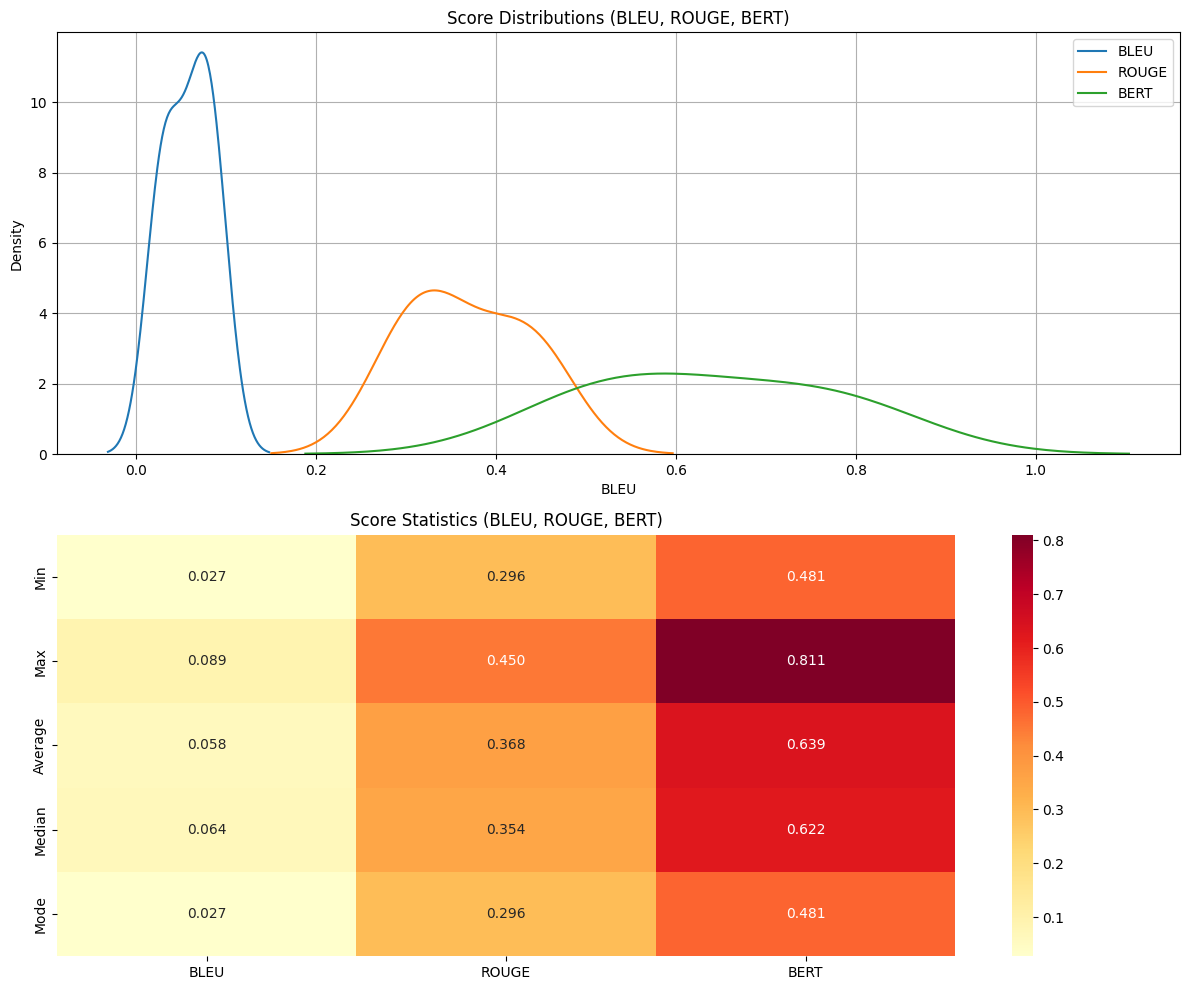

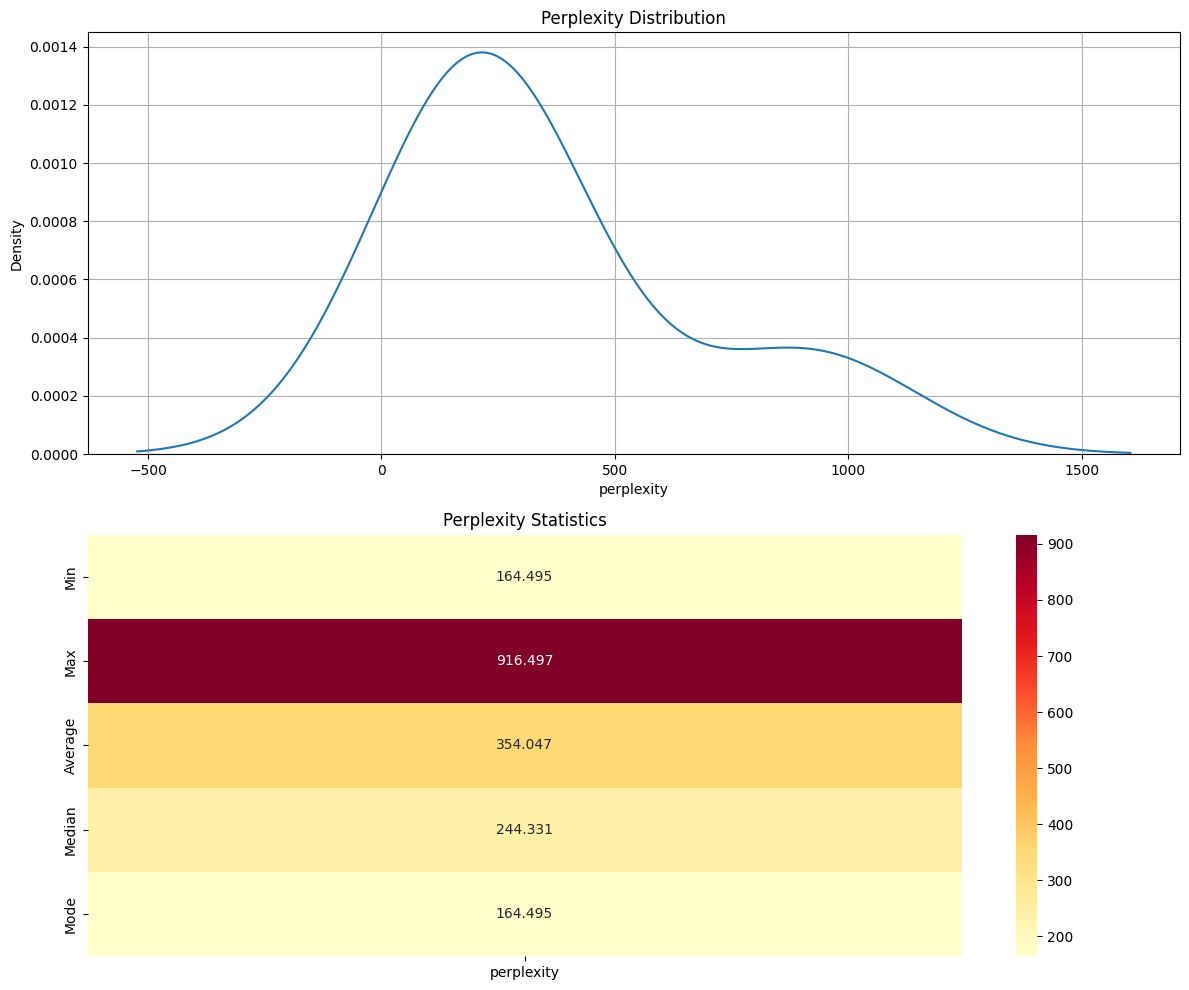

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Create figure with subplots for non-perplexity scores
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plt.grid()

# Plot distributions without perplexity
scores_without_perplexity = ['BLEU', 'ROUGE', 'BERT']
for score in scores_without_perplexity:
    sns.kdeplot(data=dreams_interpretations_df[score], label=score, ax=ax1)
ax1.set_title('Score Distributions (BLEU, ROUGE, BERT)')
ax1.legend()

# Calculate statistics for heatmap without perplexity
stats_df = pd.DataFrame()
for score in scores_without_perplexity:
    stats_df[score] = [
        dreams_interpretations_df[score].min(),
        dreams_interpretations_df[score].max(),
        dreams_interpretations_df[score].mean(),
        dreams_interpretations_df[score].median(),
        stats.mode(dreams_interpretations_df[score])[0]
    ]
stats_df.index = ['Min', 'Max', 'Average', 'Median', 'Mode']

# Plot heatmap
sns.heatmap(stats_df, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax2)
ax2.set_title('Score Statistics (BLEU, ROUGE, BERT)')
plt.tight_layout()

# Create separate figure for perplexity
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(12, 10))

# Plot perplexity distribution
sns.kdeplot(data=dreams_interpretations_df['perplexity'], ax=ax3)
ax3.set_title('Perplexity Distribution')

# Calculate perplexity statistics
perplexity_stats = pd.DataFrame({
    'perplexity': [
        dreams_interpretations_df['perplexity'].min(),
        dreams_interpretations_df['perplexity'].max(),
        dreams_interpretations_df['perplexity'].mean(),
        dreams_interpretations_df['perplexity'].median(),
        stats.mode(dreams_interpretations_df['perplexity'])[0]
    ]
})
perplexity_stats.index = ['Min', 'Max', 'Average', 'Median', 'Mode']

# Plot perplexity heatmap
sns.heatmap(perplexity_stats, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax4)
ax4.set_title('Perplexity Statistics')
plt.tight_layout()

plt.show()


We can draw the following conclusions:
1. The bleu score is incredibly low (a good result should be 20-40, we didn't even get 1...). This means that there is a weak overlap between the dream and its interpretation.
2. Same for the Rouge.
3. BERT averages at 0.6, which is not that bad considering that a good value is 0.85–0.9 that indicates some semantic similarity between the dream and its interpretation.
4. perplexity is terrible since a good value is under 20...
5. We interpret the results using this table:
| **Metric** | **High Score Meaning** | **Low Score Meaning** | **Preferred Score** | **Typical Values for Good Results** | **Why?** |
| --- | --- | --- | --- | --- | --- |
| **BLEU** | High n-gram overlap between reference and candidate text | Low n-gram overlap between reference and candidate text | **High** | 20–40 (moderate), 40+ (good) | High BLEU indicates the candidate text closely matches the reference text. |
| **Perplexity** | Candidate text is unpredictable and diverges from reference distribution | Candidate text is predictable, fluent, and aligned with reference distribution | **Low** | < 20 (for good results) | Low perplexity shows that the candidate text is fluent, consistent, and aligned with the reference. |
| **ROUGE** | More overlapping n-grams (e.g., unigrams, bigrams) and higher recall of key phrases | Fewer overlapping n-grams and poor recall of key phrases | **High** | 30–50 (good), 50+ (very good) | High ROUGE suggests greater similarity between the candidate and reference texts. |
| **BERTScore** | Strong semantic similarity between the candidate and reference text | Weak semantic similarity between the candidate and reference text | **High** | 0.85–0.98 (good) | Higher BERTScore reflects that the candidate preserves the meaning of the reference text. |

